# Predicting Crash Risk at an Intersection - XGBoost Model

## 1 Feature Selection
left out unique intersection IDs (and their one-hots) to avoid trivially memorizing “Intersection #123 always crashes.” That would give perfect training accuracy but zero generalization to new intersections.

## 2 Features
when - hour,day of week, month, is weekend
Weather - all
where - nearest intersection lat and lon, distance to intereseciton
Categorical - weather borough - one-hot encoded, the traffic and weather borough threw off my initial model with lots of nan
## 3 Hyperparemeter Tuning
trial and error
## Results
Used 3000 boosting rounds getting .9314


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier, DMatrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# reproducibility
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
df = pd.read_csv("final_balanced.csv", low_memory=False)

df.head()

,crash_date,crash_time,collision_id,borough_traffic,weather_borough,tavg,tmin,tmax,prcp,snow,...,nearest_intersection_name,nearest_intersection_lat,nearest_intersection_lon,nearest_intersection_x_ny,nearest_intersection_y_ny,distance_to_intersection_km,is_crash,day_of_week,month,is_weekend
0,2023-11-01,1:29,4675373.0,BROOKLYN,Brooklyn,8.9,3.9,11.1,0.0,0.0,...,AVE K & OCEAN PKWY,40.621792,-73.970019,9.925730e+05,165813.570502,8.269925e-08,1,2,11,0
1,2021-09-11,9:35,4456314.0,BROOKLYN,Brooklyn,21.1,13.9,27.2,0.0,0.0,...,AUTUMN AVE & LORING AVE,40.667256,-73.866074,1.021403e+06,182404.308244,5.714103e-06,1,5,9,1
2,2021-12-14,8:13,4486609.0,BROOKLYN,Brooklyn,8.7,3.3,13.3,0.0,0.0,...,DECATUR ST & DISTRICT BOUNDARY & SARATOGA AVE,40.683303,-73.917266,1.007196e+06,188233.049282,1.024554e-07,1,1,12,0
3,2021-12-14,17:05,4486555.0,NaN,Brooklyn,8.7,3.3,13.3,0.0,0.0,...,BROOKLYN QUEENS EXPY & S 5 ST,40.708876,-73.956891,9.962017e+05,197541.964310,5.433776e-06,1,1,12,0
4,2021-12-14,8:17,4486660.0,BRONX,Bronx,8.5,3.2,12.0,0.0,0.0,...,BARTOW AVE & BAYCHESTER AVE,40.868771,-73.831733,1.030789e+06,255839.112209,1.117401e-05,1,1,12,0


In [2]:
print(df.columns.tolist())

['crash_date', 'crash_time', 'collision_id', 'borough_traffic', 'weather_borough', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'borough_weather', 'x_ny_state_plane', 'y_ny_state_plane', 'nearest_intersection_id', 'nearest_intersection_name', 'nearest_intersection_lat', 'nearest_intersection_lon', 'nearest_intersection_x_ny', 'nearest_intersection_y_ny', 'distance_to_intersection_km', 'is_crash', 'day_of_week', 'month', 'is_weekend']


In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)   
df.head()


,crash_date,crash_time,collision_id,borough_traffic,weather_borough,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,borough_weather,x_ny_state_plane,y_ny_state_plane,nearest_intersection_id,nearest_intersection_name,nearest_intersection_lat,nearest_intersection_lon,nearest_intersection_x_ny,nearest_intersection_y_ny,distance_to_intersection_km,is_crash,day_of_week,month,is_weekend
0,2023-11-01,1:29,4675373.0,BROOKLYN,Brooklyn,8.9,3.9,11.1,0.0,0.0,326.0,19.4,1018.0,Brooklyn,9.925715e+05,165812.667992,17358,AVE K & OCEAN PKWY,40.621792,-73.970019,9.925730e+05,165813.570502,8.269925e-08,1,2,11,0
1,2021-09-11,9:35,4456314.0,BROOKLYN,Brooklyn,21.1,13.9,27.2,0.0,0.0,235.0,11.9,1020.6,Brooklyn,1.021285e+06,182384.297847,31301,AUTUMN AVE & LORING AVE,40.667256,-73.866074,1.021403e+06,182404.308244,5.714103e-06,1,5,9,1
2,2021-12-14,8:13,4486609.0,BROOKLYN,Brooklyn,8.7,3.3,13.3,0.0,0.0,351.0,11.5,1031.5,Brooklyn,1.007194e+06,188233.330129,27142,DECATUR ST & DISTRICT BOUNDARY & SARATOGA AVE,40.683303,-73.917266,1.007196e+06,188233.049282,1.024554e-07,1,1,12,0
3,2021-12-14,17:05,4486555.0,NaN,Brooklyn,8.7,3.3,13.3,0.0,0.0,351.0,11.5,1031.5,Brooklyn,9.962200e+05,197653.930801,19687,BROOKLYN QUEENS EXPY & S 5 ST,40.708876,-73.956891,9.962017e+05,197541.964310,5.433776e-06,1,1,12,0
4,2021-12-14,8:17,4486660.0,BRONX,Bronx,8.5,3.2,12.0,0.0,0.0,342.0,9.4,1032.2,Bronx,1.030859e+06,255616.610277,57844,BARTOW AVE & BAYCHESTER AVE,40.868771,-73.831733,1.030789e+06,255839.112209,1.117401e-05,1,1,12,0


XGBoost won't know what to do with crash_date or crash_time, pull hour from crash time, label- or one-hot–encode borough/weather categories


In [4]:
df["hour"] = pd.to_datetime(df["crash_time"], format="%H:%M").dt.hour

In [5]:
num_cols = [
    "hour",
    "day_of_week", "month", "is_weekend",
    "tavg", "prcp", "snow",
    "wdir", "wspd", "pres",
    "nearest_intersection_lat", "nearest_intersection_lon"
]
#"tmin", "tmax"
## Replace NaNs with a real label
#df["borough_traffic"] = df["borough_traffic"].fillna("Unknown")


# categorical columns to encode:
#cat_cols = ["borough_traffic", "weather_borough", "borough_weather"]
cat_cols = ["weather_borough"]

# target
y = df["is_crash"].astype(int)


In [6]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat = ohe.fit_transform(df[cat_cols])
cat_names = ohe.get_feature_names_out(cat_cols) #cat predictors

# assembling feature matrix
X_num = df[num_cols].to_numpy()
#X = np.hstack([X_num, X_cat])
X = df[num_cols].to_numpy()
feature_names = num_cols #+ list(cat_names)


In [7]:
import xgboost as xgb
from xgboost.callback import EarlyStopping
# 1a) hold out 20% as your final test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_SEED
)

# 1b) split the remaining 80% into train (60% total) and val (20% total)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,             # 0.25 * 0.80 = 0.20 of original
    stratify=y_trainval,
    random_state=RANDOM_SEED
)



params = {
    "objective":   "binary:logistic", 
    "eval_metric": "auc",
    "eta":          0.1, 
    "max_depth":    6,# 6 splits
    "seed":         RANDOM_SEED,
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,
    evals=[(dtrain, "train"), (dval, "validation")],
    callbacks=[EarlyStopping(rounds=10, save_best=True)],
    verbose_eval=False
)


val_probs = bst.predict(dval)
print("Validation AUC = {:.4f}".format(roc_auc_score(y_val, val_probs)))
dtest = xgb.DMatrix(X_test, label=y_test)
test_probs = bst.predict(dtest)
test_auc = roc_auc_score(y_test, test_probs)
print(f"Test AUC = {test_auc:.4f}")


Validation AUC = 0.9516
Test AUC = 0.9514


In [8]:

print("Best iteration:", bst.best_iteration)
print("Best validation AUC:", bst.best_score)


Best iteration: 7990
Best validation AUC: 0.9516044846816243


In [9]:
# 1) Get the raw importance dict from the booster
importance = bst.get_score(importance_type="gain")
#    e.g. {'f12': 34.27, 'f0': 21.16, ...}

# 2) Map each key 'f<idx>' back to feature_names[idx]
importances = [
    (feature_names[int(fid[1:])], gain)
    for fid, gain in importance.items()
]

# 3) Sort descending by gain
importances_sorted = sorted(importances, key=lambda x: x[1], reverse=True)


df_imp = pd.DataFrame(importances_sorted, columns=["feature", "gain"])
df_imp = df_imp.sort_values("gain", ascending=False).reset_index(drop=True)
print(df_imp.head(20))



                     feature       gain
0                       hour  69.516556
1                      month  28.707651
2                day_of_week  28.672840
3                       snow  25.672520
4                       wdir  24.145313
5                       wspd  24.106829
6                       tavg  23.328503
7                       pres  22.475700
8                       prcp  21.080992
9   nearest_intersection_lon  14.241790
10  nearest_intersection_lat  11.002351


In [10]:
# proportion of rows where borough_traffic is missing
print(df["borough_traffic"].isna().mean())

# among those missing rows, what fraction are crashes?
print(df.loc[df["borough_traffic"].isna(), "is_crash"].value_counts(normalize=True))



0.6212765384577547
0    0.804795
1    0.195205
Name: is_crash, dtype: float64


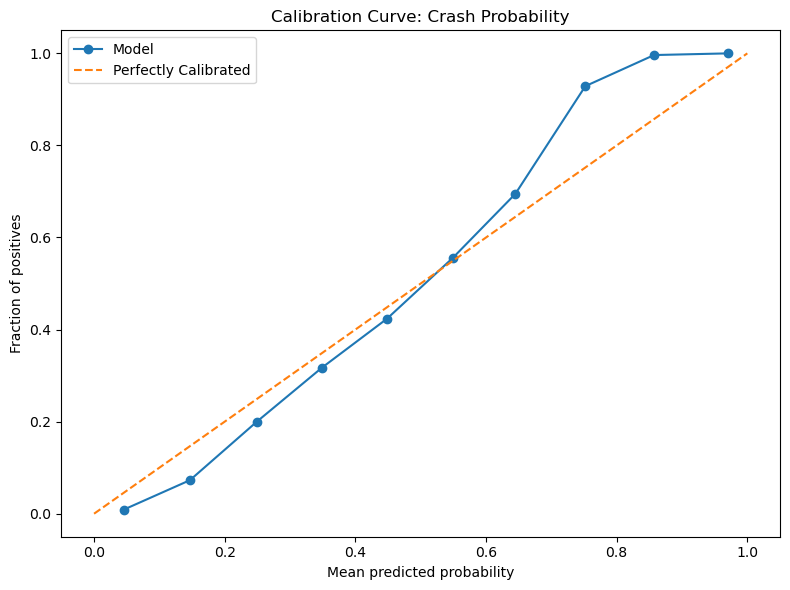

In [13]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# test_probs: model.predict(dtest)
# y_test: true labels

prob_true, prob_pred = calibration_curve(y_test, test_probs, n_bins=10)

plt.figure(figsize=(8, 6))  
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')  
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve: Crash Probability")
plt.legend()
plt.tight_layout()
plt.show()
